In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
from accelerate import Accelerator

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../../input/train/imputed/train_imputed_df.csv', sep=';')
test_df = pd.read_csv('../../input/test/imputed/test_imputed_df.csv', sep=';')

## NEW IMPUTATION ##
#train_df = pd.read_csv('../../input/train/imputed/train_imputed_df_KNN.csv', sep=';')
#test_df = pd.read_csv('../../input/train/imputed/train_imputed_df_KNN.csv', sep=';')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Age                      94379 non-null  float64
 2   Travel_Distance          94379 non-null  int64  
 3   Departure_Delay_in_Mins  94379 non-null  float64
 4   Arrival_Delay_in_Mins    94379 non-null  float64
 5   Overall_Experience       94379 non-null  float64
 6   Gender                   94379 non-null  object 
 7   Customer_Type            94379 non-null  object 
 8   Type_Travel              94379 non-null  object 
 9   Travel_Class             94379 non-null  object 
 10  Seat_Comfort             94379 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  94379 non-null  object 
 13  Catering                 94379 non-null  object 
 14  Platform_Location     

In [4]:
train_df['train_test'] = 'train'
test_df['train_test'] = 'test'
df = pd.concat([train_df, test_df])

In [5]:
df

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Gender,Customer_Type,Type_Travel,Travel_Class,...,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,train_test
0,98800001,52.0,272,0.0,5.0,0.0,Female,Loyal Customer,Personal Travel,Business,...,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor,train
1,98800002,48.0,2200,9.0,0.0,0.0,Male,Loyal Customer,Personal Travel,Eco,...,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good,train
2,98800003,43.0,1061,77.0,119.0,1.0,Female,Loyal Customer,Business Travel,Business,...,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent,train
3,98800004,44.0,780,13.0,18.0,0.0,Female,Loyal Customer,Business Travel,Business,...,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable,train
4,98800005,50.0,1981,0.0,0.0,1.0,Female,Loyal Customer,Business Travel,Business,...,Good,Excellent,Good,Good,Good,Good,Good,Good,Good,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,99935598,8.0,1334,0.0,0.0,1.0,Male,Loyal Customer,Personal Travel,Eco,...,Needs Improvement,Acceptable,Acceptable,Good,Excellent,Good,Acceptable,Good,Acceptable,test
35598,99935599,53.0,1772,0.0,0.0,1.0,Female,Loyal Customer,Business Travel,Business,...,Excellent,Excellent,Good,Good,Good,Good,Acceptable,Good,Good,test
35599,99935600,22.0,1180,0.0,0.0,0.0,Male,Disloyal Customer,Business Travel,Eco,...,Good,Poor,Needs Improvement,Poor,Acceptable,Poor,Poor,Excellent,Needs Improvement,test
35600,99935601,67.0,420,23.0,16.0,0.0,Female,Loyal Customer,Personal Travel,Eco,...,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Acceptable,Excellent,Good,test


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129981 entries, 0 to 35601
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       129981 non-null  int64  
 1   Age                      129981 non-null  float64
 2   Travel_Distance          129981 non-null  int64  
 3   Departure_Delay_in_Mins  129981 non-null  float64
 4   Arrival_Delay_in_Mins    129981 non-null  float64
 5   Overall_Experience       129981 non-null  float64
 6   Gender                   129981 non-null  object 
 7   Customer_Type            129981 non-null  object 
 8   Type_Travel              129981 non-null  object 
 9   Travel_Class             129981 non-null  object 
 10  Seat_Comfort             129981 non-null  object 
 11  Seat_Class               129981 non-null  object 
 12  Arrival_Time_Convenient  129981 non-null  object 
 13  Catering                 129981 non-null  object 
 14  Platform_L

In [7]:
# Encode categorical variables
categorical_columns = [col for col in train_df.columns if train_df[col].dtype == 'object']
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])
    df[col] =  pd.Categorical(df[col])

In [8]:
df = pd.get_dummies(df, columns = [x for x in df.columns if x not in ['train_test', 'ID', 'Age', 'Travel_Distance',	'Departure_Delay_in_Mins',	                                                                  'Arrival_Delay_in_Mins', 'Overall_Experience']])
df

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,train_test,Gender_0,Gender_1,Customer_Type_0,...,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5,Online_Boarding_0,Online_Boarding_1,Online_Boarding_2,Online_Boarding_3,Online_Boarding_4,Online_Boarding_5
0,98800001,52.0,272,0.0,5.0,0.0,1,True,False,False,...,False,False,True,False,False,False,False,False,False,True
1,98800002,48.0,2200,9.0,0.0,0.0,1,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,98800003,43.0,1061,77.0,119.0,1.0,1,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,98800004,44.0,780,13.0,18.0,0.0,1,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,98800005,50.0,1981,0.0,0.0,1.0,1,True,False,False,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,99935598,8.0,1334,0.0,0.0,1.0,0,False,True,False,...,False,True,False,False,True,False,False,False,False,False
35598,99935599,53.0,1772,0.0,0.0,1.0,0,True,False,False,...,False,True,False,False,False,False,False,True,False,False
35599,99935600,22.0,1180,0.0,0.0,0.0,0,False,True,True,...,False,False,False,False,False,False,False,False,True,False
35600,99935601,67.0,420,23.0,16.0,0.0,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [9]:
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns = numerical_columns.drop(["ID", "Overall_Experience"])
numerical_columns

Index(['Age', 'Travel_Distance', 'Departure_Delay_in_Mins',
       'Arrival_Delay_in_Mins'],
      dtype='object')

In [10]:
scaler = StandardScaler()

In [11]:
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,train_test,Gender_0,Gender_1,Customer_Type_0,...,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5,Online_Boarding_0,Online_Boarding_1,Online_Boarding_2,Online_Boarding_3,Online_Boarding_4,Online_Boarding_5
0,98800001,0.831555,-1.664281,-0.386528,-0.262763,0.0,1,True,False,False,...,False,False,True,False,False,False,False,False,False,True
1,98800002,0.567000,0.213103,-0.150056,-0.392994,0.0,1,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,98800003,0.236305,-0.895995,1.636618,2.706493,1.0,1,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,98800004,0.302444,-1.169618,-0.044958,0.075836,0.0,1,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,98800005,0.699278,-0.000148,-0.386528,-0.392994,1.0,1,True,False,False,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,99935598,-2.078556,-0.630162,-0.386528,-0.392994,1.0,0,False,True,False,...,False,True,False,False,True,False,False,False,False,False
35598,99935599,0.897694,-0.203661,-0.386528,-0.392994,1.0,0,True,False,False,...,False,True,False,False,False,False,False,True,False,False
35599,99935600,-1.152612,-0.780119,-0.386528,-0.392994,0.0,0,False,True,True,...,False,False,False,False,False,False,False,False,True,False
35600,99935601,1.823639,-1.520167,0.217789,0.023744,0.0,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [12]:
train_df = df[df['train_test']==1]
test_df = df[df['train_test']==0]

In [13]:
# Define features and target variable
X_train = train_df.drop(columns=['ID', 'Overall_Experience', 'train_test'])
y_train = train_df['Overall_Experience']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=pd.concat((X_train["Gender_0"],y_train),axis=1), random_state=42, shuffle=True, test_size=0.2)

X_test = test_df.drop(['ID', 'train_test', 'Overall_Experience'], axis=1)

<h1> Logistic Regression </h1>

In [14]:
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=42)

<h1> Preds on train </h1>

In [75]:
y_pred_log_reg = log_reg.predict(X_train)
accuracy_log_reg = accuracy_score(y_train, y_pred_log_reg)
f1_log_reg = f1_score(y_train, y_pred_log_reg, average='weighted')

In [76]:
print(f"Logistic Regression - Accuracy: {accuracy_log_reg}, F1 Score: {f1_log_reg}")
print("Classification Report:\n", classification_report(y_train, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_log_reg))

Logistic Regression - Accuracy: 0.9008648662967035, F1 Score: 0.900903820677506
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     34229
         1.0       0.91      0.91      0.91     41274

    accuracy                           0.90     75503
   macro avg       0.90      0.90      0.90     75503
weighted avg       0.90      0.90      0.90     75503

Confusion Matrix:
 [[30652  3577]
 [ 3908 37366]]


<h1> Preds on validation </h1>

In [77]:
y_pred_log_reg = log_reg.predict(X_val)
accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
f1_log_reg = f1_score(y_val, y_pred_log_reg, average='weighted')

In [78]:
print(f"Logistic Regression - Accuracy: {accuracy_log_reg}, F1 Score: {f1_log_reg}")
print("Classification Report:\n", classification_report(y_val, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_log_reg))

Logistic Regression - Accuracy: 0.8964293282475101, F1 Score: 0.8964821070519541
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      8557
         1.0       0.91      0.90      0.90     10319

    accuracy                           0.90     18876
   macro avg       0.90      0.90      0.90     18876
weighted avg       0.90      0.90      0.90     18876

Confusion Matrix:
 [[7634  923]
 [1032 9287]]


<h1> Random Forest </h1>

In [105]:
rf_model = RandomForestClassifier(random_state=42, min_samples_leaf=20)
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=20, n_estimators=500, random_state=42)

<h1> Preds on train </h1>

In [106]:
y_pred_rf = rf_model.predict(X_train)
accuracy_rf = accuracy_score(y_train, y_pred_rf)
f1_rf = f1_score(y_train, y_pred_rf, average='weighted')

In [107]:
print(f"Random Forest - Accuracy: {accuracy_rf}, F1 Score: {f1_rf}")
print("Classification Report:\n", classification_report(y_train, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_rf))

Random Forest - Accuracy: 0.9401083400659577, F1 Score: 0.9400951784473228
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.93      0.93     34229
         1.0       0.94      0.95      0.95     41274

    accuracy                           0.94     75503
   macro avg       0.94      0.94      0.94     75503
weighted avg       0.94      0.94      0.94     75503

Confusion Matrix:
 [[31882  2347]
 [ 2175 39099]]


<h1> Preds on validation </h1>

In [108]:
y_pred_log_reg = rf_model.predict(X_val)
accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
f1_log_reg = f1_score(y_val, y_pred_log_reg, average='weighted')

In [109]:
print(f"Logistic Regression - Accuracy: {accuracy_log_reg}, F1 Score: {f1_log_reg}")
print("Classification Report:\n", classification_report(y_val, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_log_reg))

Logistic Regression - Accuracy: 0.9312354312354313, F1 Score: 0.9312270839935167
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      8557
         1.0       0.94      0.94      0.94     10319

    accuracy                           0.93     18876
   macro avg       0.93      0.93      0.93     18876
weighted avg       0.93      0.93      0.93     18876

Confusion Matrix:
 [[7896  661]
 [ 637 9682]]


<h1> SVM </h1>

In [63]:
svm_model = svm.SVC(cache_size=2000, random_state=42)
svm_model.fit(X_train, y_train)

SVC(cache_size=2000, random_state=42)

<h1> Preds on train </h1>

In [64]:
y_pred_gb = svm_model.predict(X_train)
accuracy_gb = accuracy_score(y_train, y_pred_gb)
f1_gb = f1_score(y_train, y_pred_gb, average='weighted')

In [65]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_train, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gb))

Gradient Boosting - Accuracy: 0.9620279988874614, F1 Score: 0.9620563858841568
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     34229
         1.0       0.97      0.96      0.96     41274

    accuracy                           0.96     75503
   macro avg       0.96      0.96      0.96     75503
weighted avg       0.96      0.96      0.96     75503

Confusion Matrix:
 [[33127  1102]
 [ 1765 39509]]


<h1> Preds on validation </h1>

In [66]:
y_pred_gb = svm_model.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

In [67]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))

Gradient Boosting - Accuracy: 0.9496185632549269, F1 Score: 0.9496674161941114
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      8557
         1.0       0.96      0.94      0.95     10319

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876

Confusion Matrix:
 [[8193  364]
 [ 587 9732]]


<h1> Gradient Boosting </h1>

In [123]:
gb_model = GradientBoostingClassifier(random_state=42, min_samples_leaf=50)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=50, random_state=42)

<h1> Preds on train </h1>

In [124]:
y_pred_gb = gb_model.predict(X_train)
accuracy_gb = accuracy_score(y_train, y_pred_gb)
f1_gb = f1_score(y_train, y_pred_gb, average='weighted')

In [125]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_train, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gb))

Gradient Boosting - Accuracy: 0.922294478365098, F1 Score: 0.9223126540047661
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91     34229
         1.0       0.93      0.93      0.93     41274

    accuracy                           0.92     75503
   macro avg       0.92      0.92      0.92     75503
weighted avg       0.92      0.92      0.92     75503

Confusion Matrix:
 [[31392  2837]
 [ 3030 38244]]


<h1> Preds on validation </h1>

In [126]:
y_pred_gb = gb_model.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

In [127]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))

Gradient Boosting - Accuracy: 0.9185738503920322, F1 Score: 0.9186117692700915
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      8557
         1.0       0.93      0.92      0.93     10319

    accuracy                           0.92     18876
   macro avg       0.92      0.92      0.92     18876
weighted avg       0.92      0.92      0.92     18876

Confusion Matrix:
 [[7838  719]
 [ 818 9501]]


<h1>AdaBoost</h1>

In [42]:
adaboost = AdaBoostClassifier(n_estimators=500,algorithm="SAMME",random_state=42)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=500, random_state=42)

<h1> Preds on train </h1>

In [43]:
y_pred_gb = adaboost.predict(X_train)
accuracy_gb = accuracy_score(y_train, y_pred_gb)
f1_gb = f1_score(y_train, y_pred_gb, average='weighted')

In [44]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_train, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gb))

Gradient Boosting - Accuracy: 0.8972358714223276, F1 Score: 0.8972628011977463
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89     34229
         1.0       0.91      0.90      0.91     41274

    accuracy                           0.90     75503
   macro avg       0.90      0.90      0.90     75503
weighted avg       0.90      0.90      0.90     75503

Confusion Matrix:
 [[30458  3771]
 [ 3988 37286]]


<h1> Preds on validation </h1>

In [45]:
y_pred_gb = adaboost.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

In [46]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))

Gradient Boosting - Accuracy: 0.893674507310871, F1 Score: 0.8937351234492799
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.88      8557
         1.0       0.91      0.90      0.90     10319

    accuracy                           0.89     18876
   macro avg       0.89      0.89      0.89     18876
weighted avg       0.89      0.89      0.89     18876

Confusion Matrix:
 [[7615  942]
 [1065 9254]]


<h1>XGBoost</h1>

In [85]:
xgboost = XGBClassifier(n_estimators=300,
                     max_depth=10,
                     max_leaves=64,
                     eta=0.1,
                     reg_lambda=0,
                     tree_method='hist',
                     eval_metric='logloss',
                     use_label_encoder=False,
                     random_state=42,
                     n_jobs=-1)

xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=64, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

<h1> Preds on train </h1>

In [86]:
y_pred_gb = xgboost.predict(X_train)
accuracy_gb = accuracy_score(y_train, y_pred_gb)
f1_gb = f1_score(y_train, y_pred_gb, average='weighted')

In [87]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_train, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_gb))

Gradient Boosting - Accuracy: 0.9798551050951618, F1 Score: 0.9798627933441618
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     34229
         1.0       0.99      0.98      0.98     41274

    accuracy                           0.98     75503
   macro avg       0.98      0.98      0.98     75503
weighted avg       0.98      0.98      0.98     75503

Confusion Matrix:
 [[33629   600]
 [  921 40353]]


<h1> Preds on validation </h1>

In [88]:
y_pred_gb = xgboost.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb, average='weighted')

In [89]:
print(f"Gradient Boosting - Accuracy: {accuracy_gb}, F1 Score: {f1_gb}")
print("Classification Report:\n", classification_report(y_val, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_gb))

Gradient Boosting - Accuracy: 0.9516317016317016, F1 Score: 0.9516692853226489
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      8557
         1.0       0.96      0.95      0.96     10319

    accuracy                           0.95     18876
   macro avg       0.95      0.95      0.95     18876
weighted avg       0.95      0.95      0.95     18876

Confusion Matrix:
 [[8187  370]
 [ 543 9776]]


<h1> Multilayer Perceptron </h1>

In [173]:
# Build the neural network model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_initializer='uniform'))
#model.add(Dropout(0.5))
model.add(Dense(8, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [174]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.01),
    tf.keras.callbacks.ReduceLROnPlateau()
]

In [175]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [176]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,745 (6.82 KB)

 Trainable params: 1,745 (6.82 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50


2024-06-24 21:30:32.769023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2360/2360 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.5422 - loss: 0.6900 - val_accuracy: 0.5467 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 2/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5433 - loss: 0.6894 - val_accuracy: 0.5467 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 3/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5468 - loss: 0.6888 - val_accuracy: 0.5467 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 4/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5465 - loss: 0.6889 - val_accuracy: 0.5467 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 5/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6187 - loss: 0.6127 - val_accuracy: 0.8939 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 6/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8943 - loss: 0.2789 - val_accuracy: 0.9136 - val_loss: 0.1994 - learning_rate: 0.0010
Epoch 7/50
2360/2360 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9070 - loss:

In [45]:
# Evaluate the model
y_pred_prob = model.predict(X_val)
y_pred =  np.round(y_pred_prob)

accuracy_nn = accuracy_score(y_val, y_pred)
f1_nn = f1_score(y_val, y_pred, average='weighted')
print(f"Neural Network - Accuracy: {accuracy_nn}, F1 Score: {f1_nn}")
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network - Accuracy: 0.94642932824751, F1 Score: 0.9465113632990493
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     10697
         1.0       0.97      0.93      0.95     12898

    accuracy                           0.95     23595
   macro avg       0.95      0.95      0.95     23595
weighted avg       0.95      0.95      0.95     23595

Confusion Matrix:
 [[10314   383]
 [  881 12017]]


In [52]:
# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred =  np.round(y_pred_prob)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [53]:
predictions = pd.DataFrame(y_pred)
predictions['ID'] = test_df['ID']

In [55]:
predictions = predictions[['ID', 0]]
predictions.columns = ['ID', 'Overall_Experience']

In [60]:
predictions['Overall_Experience'] = predictions['Overall_Experience'].astype('int64')

In [61]:
predictions.to_csv('../output/submission2.csv', sep=';', index=False)

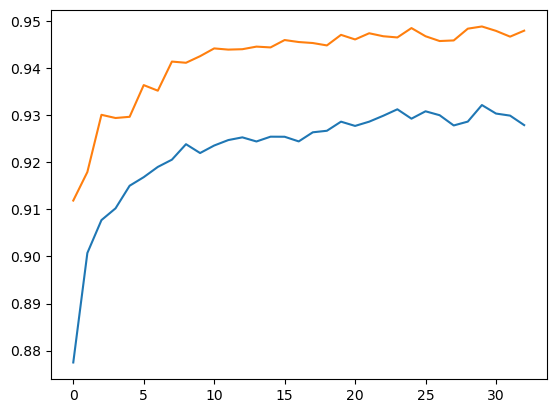

In [54]:
plt.plot(range(33), history.history['accuracy'])
plt.plot(range(33), history.history['val_accuracy'])

In [47]:
import numpy as np
np.round(y_pred_prob)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

(array([26418.,   947.,   801.,   938.,  4200.,   818.,   644.,   762.,
         1081., 34175.]),
 array([1.41081642e-32, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

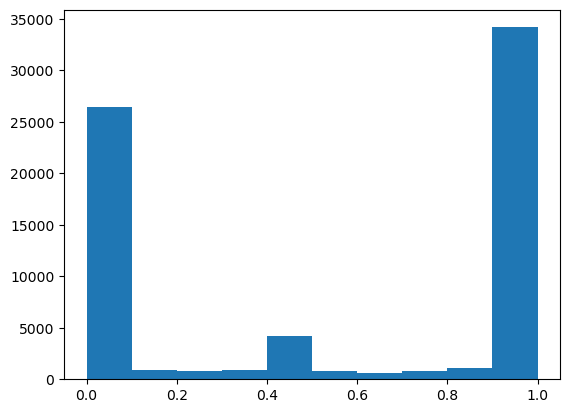

In [43]:
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)

<h1> Text Embeddings</h1>

In [4]:
train_df_bert = pd.read_csv('../../input/train/merged/train_merged.csv', sep=';')
test_df_bert = pd.read_csv('../../input/test/merged/test_merged.csv', sep=';')

X_train_bert = train_df_bert.drop(columns=['ID'])
y_train_bert = train_df_bert['Overall_Experience']

In [5]:
X_train_bert.columns

Index(['Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class',
       'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins',
       'Overall_Experience', 'Seat_Comfort', 'Seat_Class',
       'Arrival_Time_Convenient', 'Catering', 'Platform_Location',
       'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
       'Baggage_Handling', 'CheckIn_Service', 'Cleanliness',
       'Online_Boarding'],
      dtype='object')

In [6]:
def create_story(row):
    story_parts = []

    # Iterar sobre las columnas y agregar texto a la historia
    if pd.notna(row['Gender']):
        story_parts.append(f"The passenger is {row['Gender']}.")
    
    if pd.notna(row['Customer_Type']):
        story_parts.append(f"This person is a {row['Customer_Type']} customer.")
    
    if pd.notna(row['Age']):
        story_parts.append(f"The passenger's age is {row['Age']} years old.")
    
    if pd.notna(row['Type_Travel']):
        story_parts.append(f"The passenger is traveling for {row['Type_Travel']}.")
    
    if pd.notna(row['Travel_Class']):
        story_parts.append(f"The passenger is in {row['Travel_Class']} class.")
    
    if pd.notna(row['Travel_Distance']):
        story_parts.append(f"The travel distance is {row['Travel_Distance']} kilometers.")
    
    if pd.notna(row['Departure_Delay_in_Mins']):
        story_parts.append(f"The departure delay was {row['Departure_Delay_in_Mins']} minutes.")
    
    if pd.notna(row['Arrival_Delay_in_Mins']):
        story_parts.append(f"The arrival delay was {row['Arrival_Delay_in_Mins']} minutes.")
    
    if pd.notna(row['Seat_Comfort']):
        story_parts.append(f"The seat comfort is rated {row['Seat_Comfort']}.")
    
    if pd.notna(row['Seat_Class']):
        story_parts.append(f"The seat class is {row['Seat_Class']}.")
    
    if pd.notna(row['Arrival_Time_Convenient']):
        story_parts.append(f"The arrival time convenience is rated {row['Arrival_Time_Convenient']}.")
    
    if pd.notna(row['Catering']):
        story_parts.append(f"The catering service is rated {row['Catering']}.")
    
    if pd.notna(row['Platform_Location']):
        story_parts.append(f"The platform location is rated {row['Platform_Location']}.")
    
    if pd.notna(row['Onboard_Wifi_Service']):
        story_parts.append(f"The onboard wifi service is rated {row['Onboard_Wifi_Service']}.")
    
    if pd.notna(row['Onboard_Entertainment']):
        story_parts.append(f"The onboard entertainment is rated {row['Onboard_Entertainment']}.")
    
    if pd.notna(row['Online_Support']):
        story_parts.append(f"The online support is rated {row['Online_Support']}.")
    
    if pd.notna(row['Ease_of_Online_Booking']):
        story_parts.append(f"The ease of online booking is rated {row['Ease_of_Online_Booking']}.")
    
    if pd.notna(row['Onboard_Service']):
        story_parts.append(f"The onboard service is rated {row['Onboard_Service']}.")
    
    if pd.notna(row['Legroom']):
        story_parts.append(f"The legroom is rated {row['Legroom']}.")
    
    if pd.notna(row['Baggage_Handling']):
        story_parts.append(f"The baggage handling is rated {row['Baggage_Handling']}.")
    
    if pd.notna(row['CheckIn_Service']):
        story_parts.append(f"The check-in service is rated {row['CheckIn_Service']}.")
    
    if pd.notna(row['Cleanliness']):
        story_parts.append(f"The cleanliness is rated {row['Cleanliness']}.")
    
    if pd.notna(row['Online_Boarding']):
        story_parts.append(f"The online boarding is rated {row['Online_Boarding']}.")

    return ' '.join(story_parts)

# Crear una nueva columna en el dataframe con las historias
train_df_bert['story'] = train_df_bert.apply(create_story, axis=1)

### Transfer learning

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Cargar el dataframe y realizar el split
train_df, val_df = train_test_split(train_df_bert[['story', 'Overall_Experience']], test_size=0.2)

# Convertir los dataframes de pandas en datasets de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Cargar el tokenizer y el modelo de BERT
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizar los datasets
def preprocess_function(examples):
    return tokenizer(examples['story'], truncation=True, padding='max_length', max_length=512)

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Overall_Experience'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Overall_Experience'])

# Definir los DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)

# Definir el modelo Lightning
class BERTClassifier(pl.LightningModule):
    def __init__(self, model_name, num_labels, train_loader, val_loader):
        super(BERTClassifier, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.train_loader = train_loader
        self.val_loader = val_loader

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['Overall_Experience']
        outputs = self(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['Overall_Experience']
        outputs = self(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss = outputs.loss

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_acc = accuracy_score(labels.cpu(), preds.cpu())

        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_acc', val_acc, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=len(self.train_loader) * 3)
        return [optimizer], [scheduler]

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

# Configurar el logger y los callbacks
logger = TensorBoardLogger("tb_logs", name="bert_classifier")
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='checkpoints', filename='bert-{epoch:02d}-{val_loss:.2f}', save_top_k=1, mode='min')

# Instanciar el modelo y el entrenador Lightning
model = BERTClassifier(model_name=model_name, num_labels=2, train_loader=train_dataloader, val_loader=val_dataloader)
trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[checkpoint_callback])

# Entrenar el modelo
trainer.fit(model)

# Evaluar el modelo (opcional, puedes agregar un DataLoader para evaluación)


Map:   0%|          | 0/75503 [00:00<?, ? examples/s]

Map:   0%|          | 0/18876 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/moury/miniforge3/envs/kinki/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/moury/Documents/2024/MIT/Hackathon/kinki_adsp/notebooks/0_EDA/checkpoints exists and is not empty.
/Users/moury/miniforge3/envs/kinki/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Ty

Sanity Checking: |                                                                                            …

/Users/moury/miniforge3/envs/kinki/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/moury/miniforge3/envs/kinki/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

### Submissions

### Gradient Boosting

In [ ]:
y_pred_gb = gb_model.predict(X_test)

In [33]:
predictions = pd.DataFrame(y_pred_rf)
predictions['ID'] = test_df['ID']

predictions = predictions[['ID', 0]]
predictions.columns = ['ID', 'Overall_Experience']
predictions

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1
...,...,...
35597,99935598,0
35598,99935599,1
35599,99935600,1
35600,99935601,1


In [35]:
predictions.to_csv('../output/submission.csv', sep=';', index=False)

### Random Forest

In [27]:
y_pred_rf = rf_model.predict(X_test)

In [33]:
predictions = pd.DataFrame(y_pred_rf)
predictions['ID'] = test_df['ID']

predictions = predictions[['ID', 0]]
predictions.columns = ['ID', 'Overall_Experience']
predictions

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1
...,...,...
35597,99935598,0
35598,99935599,1
35599,99935600,1
35600,99935601,1


In [35]:
predictions.to_csv('../output/submission.csv', sep=';', index=False)

### XGBoost

In [90]:
y_pred_xgb = xgboost.predict(X_test)

In [91]:
predictions = pd.DataFrame(y_pred_xgb)
predictions['ID'] = test_df['Ifrom xgboost import plot_importance
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(22, 15))

# plot feature importance
plot_importance(xgboost_model, ax=ax)  # Asegúrate de que `xgboost_model` es el modelo entrenado de XGBoost

plt.show()D']

predictions = predictions[['ID', 0]]
predictions.columns = ['ID', 'Overall_Experience']
predictions

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1
...,...,...
35597,99935598,0
35598,99935599,1
35599,99935600,0
35600,99935601,1


In [168]:
predictions.to_csv('../../output/submission_xgb.csv', sep=';', index=False)

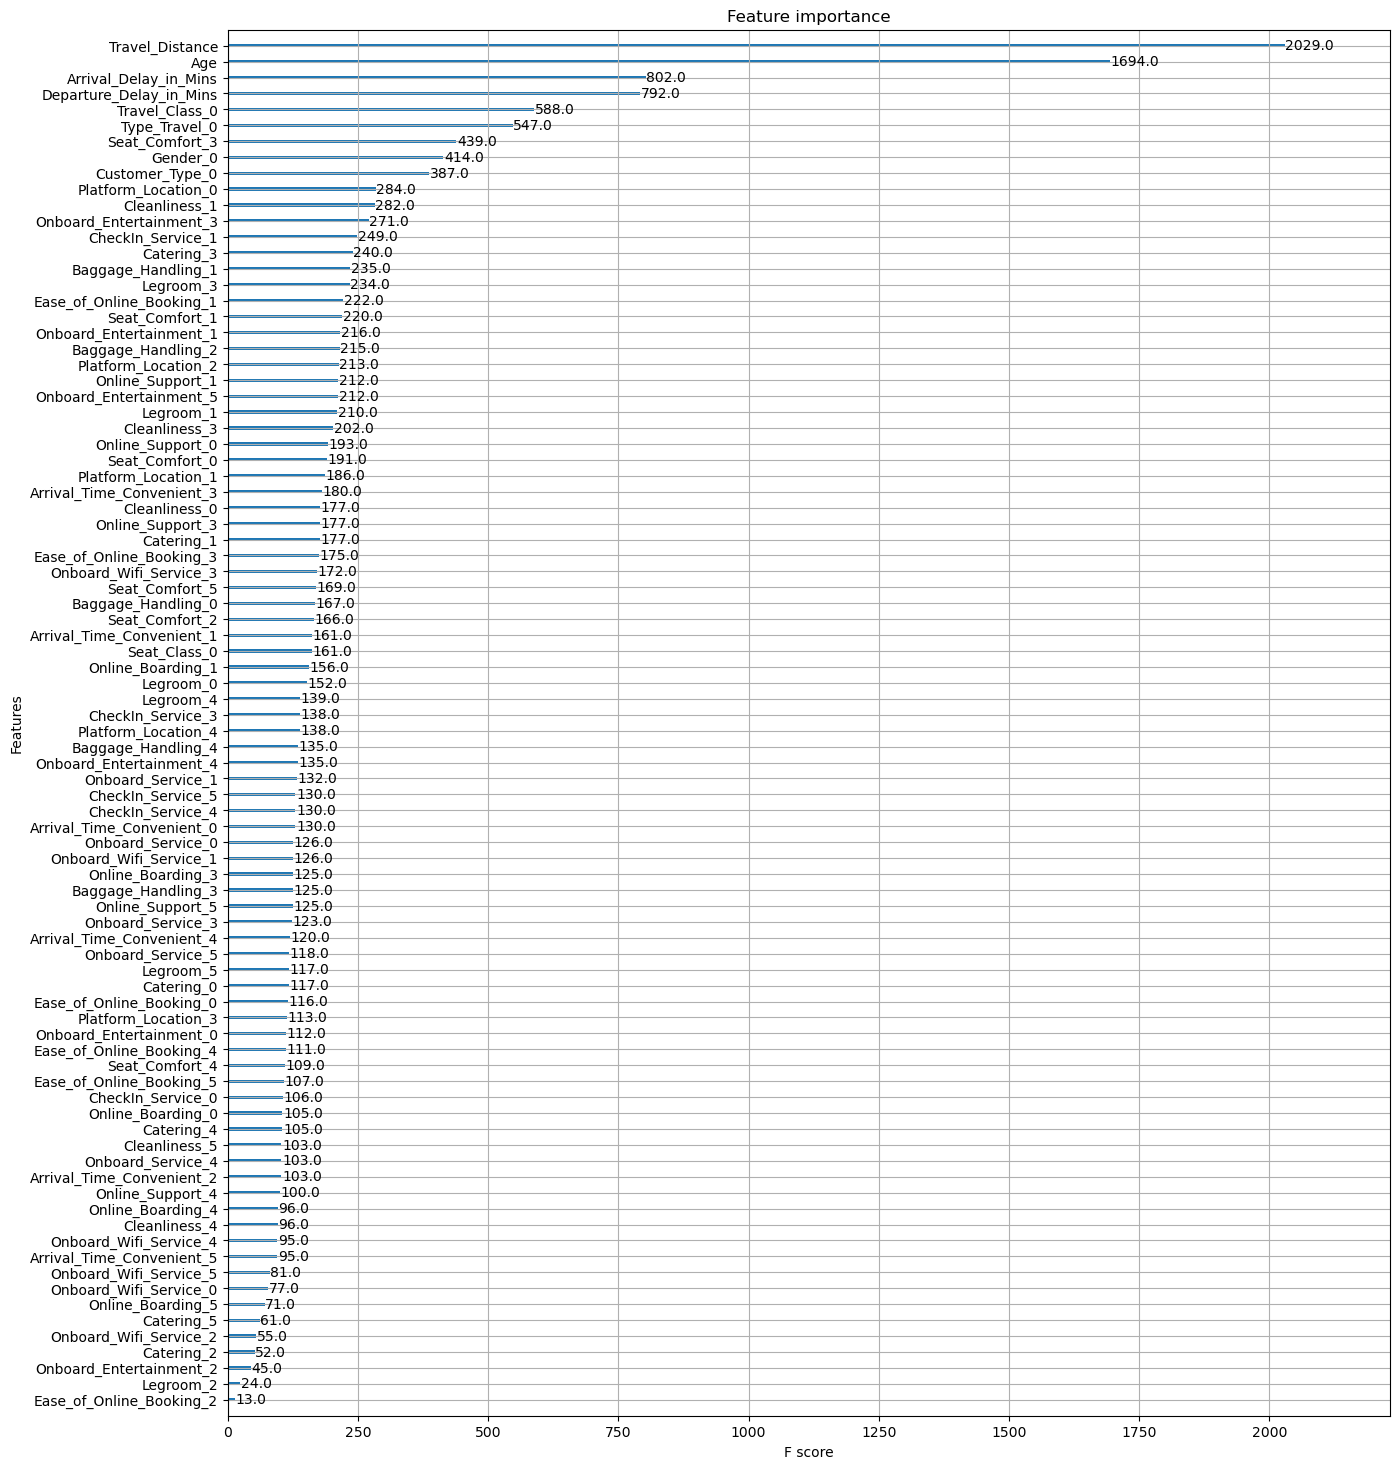

In [106]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(15, 18))

# plot feature importance
plot_importance(xgboost, ax=ax)  # Asegúrate de que `xgboost_model` es el modelo entrenado de XGBoost

plt.show()